Upload File: for execution in google colab for Fast execution

In [1]:
from google.colab import files
files.upload()

Output hidden; open in https://colab.research.google.com to view.

Make project folder

In [2]:
!mkdir -p failure-aware-cv/results/Model
!mv resnet18_cifar10_fc_only.pth failure-aware-cv/results/Model/

In [3]:
%cd /content/failure-aware-cv

/content/failure-aware-cv


Degradation Functions

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance, ImageFilter
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

Load Trained Model

In [5]:
model = torchvision.models.resnet18(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, 10)

model.load_state_dict(
    torch.load("results/Model/resnet18_cifar10_fc_only.pth", map_location=device)
)

model = model.to(device)
model.eval()

for p in model.parameters():
    p.requires_grad = False

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Dataset & Transforms

In [6]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

test_dataset = torchvision.datasets.CIFAR10(
    root="./data",
    train=False,
    download=True,
    transform=transform
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False
)

100%|██████████| 170M/170M [00:13<00:00, 12.8MB/s]


Degradation Functions

In [7]:
def add_gaussian_noise(img, severity=0.3):
    arr = np.array(img).astype(np.float32) / 255.0
    noise = np.random.normal(0, severity, arr.shape)
    noisy = np.clip(arr + noise, 0, 1)
    return Image.fromarray((noisy * 255).astype(np.uint8))

def apply_blur(img, radius=2):
    return img.filter(ImageFilter.GaussianBlur(radius))

def low_light(img, factor=0.4):
    return ImageEnhance.Brightness(img).enhance(factor)


Entropy Function

In [8]:
def compute_entropy(probs):
    probs = probs + 1e-12
    return -torch.sum(probs * torch.log(probs)).item()

Collect Confidence, Entropy, Correctness

In [9]:
def collect_signals(loader, degradation=None):
    records = []

    for img, label in tqdm(loader):
        label = label.item()
        pil_img = transforms.ToPILImage()(img[0])

        if degradation == "blur":
            pil_img = apply_blur(pil_img)
        elif degradation == "low_light":
            pil_img = low_light(pil_img)

        img_tensor = transform(pil_img).unsqueeze(0).to(device)

        with torch.no_grad():
            logits = model(img_tensor)
            probs = F.softmax(logits, dim=1)[0]

        records.append({
            "confidence": probs.max().item(),
            "entropy": compute_entropy(probs),
            "correct": int(probs.argmax().item() == label)
        })

    return pd.DataFrame(records)

Run Signal Collection

In [10]:
df_clean = collect_signals(test_loader)
df_blur = collect_signals(test_loader, "blur")
df_low = collect_signals(test_loader, "low_light")

100%|██████████| 10000/10000 [01:03<00:00, 157.61it/s]


Threshold Sweep Logic

In [11]:
conf_thresholds = np.arange(0.3, 0.91, 0.1)
entropy_thresholds = np.arange(0.5, 1.51, 0.2)

Coverage & Selective Accuracy Computation

In [12]:
def sweep_confidence(df, thresholds):
    rows = []

    for t in thresholds:
        confident = df[df["confidence"] >= t]

        coverage = len(confident) / len(df)
        selective_acc = confident["correct"].mean() if len(confident) > 0 else np.nan

        rows.append({
            "confidence_threshold": t,
            "coverage": coverage,
            "selective_accuracy": selective_acc
        })

    return pd.DataFrame(rows)

Run Sweep (All Conditions)

In [13]:
sweep_clean = sweep_confidence(df_clean, conf_thresholds)
sweep_blur = sweep_confidence(df_blur, conf_thresholds)
sweep_low = sweep_confidence(df_low, conf_thresholds)

Table Output

In [14]:
sweep_clean

,confidence_threshold,coverage,selective_accuracy
0,0.3,0.9922,0.809716
1,0.4,0.9561,0.827738
2,0.5,0.8890,0.855568
3,0.6,0.7972,0.891495
4,0.7,0.7096,0.917559
5,0.8,0.6033,0.944969
6,0.9,0.4687,0.972904


In [15]:
sweep_blur

,confidence_threshold,coverage,selective_accuracy
0,0.3,0.9742,0.617943
1,0.4,0.8813,0.651311
2,0.5,0.7440,0.703629
3,0.6,0.5984,0.757186
4,0.7,0.4713,0.810736
5,0.8,0.3419,0.869260
6,0.9,0.2096,0.932729


In [16]:
sweep_low

,confidence_threshold,coverage,selective_accuracy
0,0.3,0.9484,0.617039
1,0.4,0.8183,0.659782
2,0.5,0.6391,0.724456
3,0.6,0.4836,0.782465
4,0.7,0.3530,0.844193
5,0.8,0.2384,0.890520
6,0.9,0.1312,0.952744


Table Output - Save

In [17]:
sweep_clean.to_csv("results/threshold_sweep_clean.csv", index=False)
sweep_blur.to_csv("results/threshold_sweep_blur.csv", index=False)
sweep_low.to_csv("results/threshold_sweep_low_light.csv", index=False)

Plot: Coverage vs Selective Accuracy

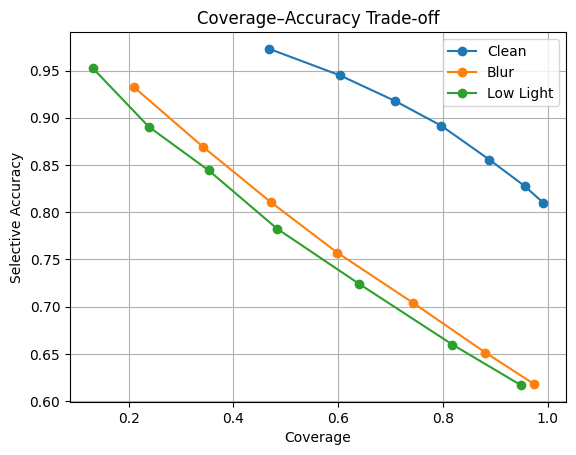

In [18]:
plt.figure()
plt.plot(sweep_clean["coverage"], sweep_clean["selective_accuracy"], marker='o', label="Clean")
plt.plot(sweep_blur["coverage"], sweep_blur["selective_accuracy"], marker='o', label="Blur")
plt.plot(sweep_low["coverage"], sweep_low["selective_accuracy"], marker='o', label="Low Light")

plt.xlabel("Coverage")
plt.ylabel("Selective Accuracy")
plt.title("Coverage–Accuracy Trade-off")
plt.legend()
plt.grid(True)
plt.show()